In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [3]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [4]:
# Load data
market_df = pd.read_excel("CL_Datasim.xlsx", engine="openpyxl")
tweets_df = pd.read_excel("merged_tweets.xlsx", engine="openpyxl")

In [5]:
# Parse datetime
market_df["Dates"] = pd.to_datetime(market_df["Dates"])
tweets_df["Timestamp"] = pd.to_datetime(tweets_df["Timestamp"], utc=True).dt.tz_convert(None)

In [6]:
# Compute Mid_Price
market_df["Mid_Price"] = market_df[["Mid_Open", "Mid_High", "Mid_Low", "Mid_Close"]].mean(axis=1)

In [7]:
# Set Dates as index for fast access
market_df.set_index("Dates", inplace=True)

In [8]:
# Time horizons to evaluate impact
time_horizons = {
    "MI_1min": timedelta(minutes=1),
    "MI_5min": timedelta(minutes=5),
    "MI_15min": timedelta(minutes=15),
    "MI_30min": timedelta(minutes=30),
    "MI_1h": timedelta(hours=1),
    "MI_2h": timedelta(hours=2),
    "MI_4h": timedelta(hours=4),
    "MI_8h": timedelta(hours=8),
    "MI_12h": timedelta(hours=12),
    "MI_1d": timedelta(days=1),
    "MI_2d": timedelta(days=2),
    "MI_3d": timedelta(days=3),
    "MI_4d": timedelta(days=4),
}

In [ ]:
results = []

for _, row in tweets_df.iterrows():
    tweet_time = row["Timestamp"]
    tweet_id = row["tweet_id"]
    tweet_text = row["Tweet"]

    # Determine execution time
    base_time = market_df.index[market_df.index <= tweet_time].max()
    if pd.isna(base_time):
        continue

    if tweet_time not in market_df.index:
        # Market closed: use last price before and delay metrics
        execution_time = base_time
        execution_price = market_df.loc[execution_time, "Mid_Open"]
        delayed_flag = True
    else:
        execution_time = tweet_time
        execution_price = market_df.loc[execution_time, "Mid_Open"]
        delayed_flag = False

    impact_row = {
    "tweet_ID": tweet_id,
    "Timestamp": tweet_time,
    "Twitter_acc": row["Twitter_acc"],  # <-- Add this line
    "Tweet": tweet_text,
    "Mid_Open_Execution": execution_price,
    "Execution_Delayed": delayed_flag
    }
    
    for label, delta in time_horizons.items():
        if delayed_flag:
            # Delay: anchor interval deltas from the *first tradable minute after tweet*
            anchor_time = market_df.index[market_df.index > tweet_time].min()
        else:
            anchor_time = tweet_time

        target_time = anchor_time + delta
        future_time = market_df.index[market_df.index >= target_time].min()

        if pd.isna(future_time):
            impact_row[f"{label}_MidOpen"] = np.nan
            impact_row[f"{label}_MidClose"] = np.nan
            continue

        # Market Impact: MidOpen
        try:
            future_open = market_df.loc[future_time, "Mid_Open"]
            impact_row[f"{label}_MidOpen"] = ((future_open - execution_price) / execution_price) * 10000
        except KeyError:
            impact_row[f"{label}_MidOpen"] = np.nan

        # Market Impact: MidClose
        try:
            future_close = market_df.loc[future_time, "Mid_Close"]
            impact_row[f"{label}_MidClose"] = ((future_close - execution_price) / execution_price) * 10000
        except KeyError:
            impact_row[f"{label}_MidClose"] = np.nan

    results.append(impact_row)

MI_1min: correlation between MI and spread widening = -0.136
MI_5min: correlation between MI and spread widening = -0.024
MI_15min: correlation between MI and spread widening = -0.056
MI_30min: correlation between MI and spread widening = -0.037
MI_1h: correlation between MI and spread widening = 0.001
MI_4h: correlation between MI and spread widening = 0.068
MI_8h: correlation between MI and spread widening = 0.199
MI_12h: correlation between MI and spread widening = 0.271
MI_1d: correlation between MI and spread widening = 0.170
MI_2h: correlation between MI and spread widening = 0.034
MI_2d: correlation between MI and spread widening = 0.058
MI_3d: correlation between MI and spread widening = 0.093
MI_4d: correlation between MI and spread widening = 0.290


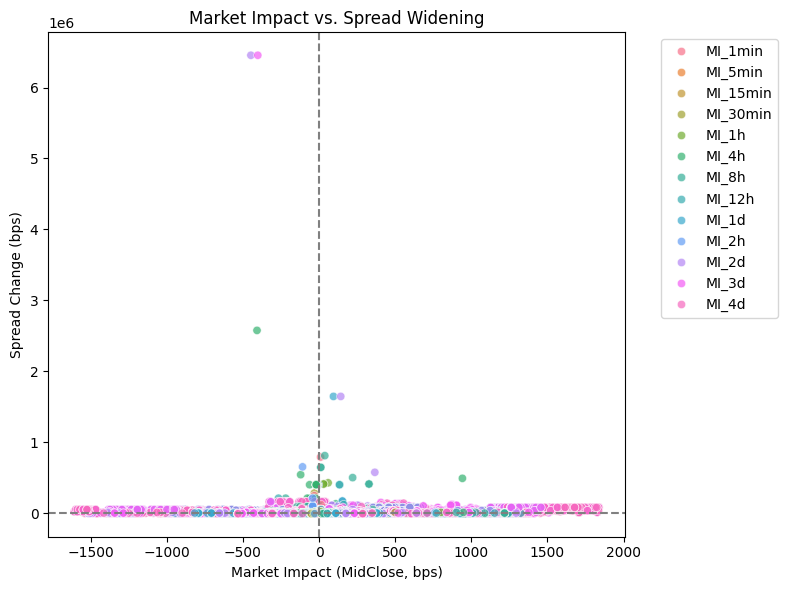

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

spread_results = []

for row in results:
    tweet_time = row["Timestamp"]
    tweet_id = row["tweet_ID"]
    delayed = row["Execution_Delayed"]

    base_time = market_df.index[market_df.index <= tweet_time].max()
    if pd.isna(base_time):
        continue

    try:
        base_spread = market_df.loc[base_time, "Spread_Close"]
    except KeyError:
        continue

    for label, delta in time_horizons.items():
        if delayed:
            anchor_time = market_df.index[market_df.index > tweet_time].min()
        else:
            anchor_time = tweet_time

        target_time = anchor_time + delta
        future_time = market_df.index[market_df.index >= target_time].min()

        if pd.isna(future_time):
            continue

        try:
            future_spread = market_df.loc[future_time, "Spread_Close"]
            spread_change_bps = ((future_spread - base_spread) / base_spread) * 10000 if base_spread != 0 else np.nan
            market_impact = row.get(f"{label}_MidClose")
            spread_results.append({
                "tweet_ID": tweet_id,
                "Horizon": label,
                "MarketImpact_bps": market_impact,
                "SpreadChange_bps": spread_change_bps
            })
        except KeyError:
            continue

# Create DataFrame
spread_df = pd.DataFrame(spread_results)

# Drop rows with NaNs
spread_df = spread_df.dropna()

# Plot correlation at each time horizon
for horizon in spread_df["Horizon"].unique():
    subset = spread_df[spread_df["Horizon"] == horizon]
    corr = subset["MarketImpact_bps"].corr(subset["SpreadChange_bps"])
    print(f"{horizon}: correlation between MI and spread widening = {corr:.3f}")

# Optional: visualize
plt.figure(figsize=(8,6))
sns.scatterplot(data=spread_df, x="MarketImpact_bps", y="SpreadChange_bps", hue="Horizon", alpha=0.7)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Market Impact vs. Spread Widening")
plt.xlabel("Market Impact (MidClose, bps)")
plt.ylabel("Spread Change (bps)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [36]:
# Pivot spread_df to wide format
spread_wide = spread_df.pivot(index="tweet_ID", columns="Horizon", values="SpreadChange_bps")

# Flatten column names like "MI_1min" → "MI_1min_SpreadChange_bps"
spread_wide.columns = [f"{col}_SpreadChange_bps" for col in spread_wide.columns]

# Reset index so tweet_ID becomes a column
spread_wide.reset_index(inplace=True)

# Merge into impact_df
impact_df = pd.merge(impact_df, spread_wide, on="tweet_ID", how="right")

# Optional: move all SpreadChange columns to the end
spread_cols = [col for col in impact_df.columns if col.endswith("_SpreadChange_bps")]
other_cols = [col for col in impact_df.columns if col not in spread_cols]
impact_df = impact_df[other_cols + spread_cols]

In [41]:
# Save to Excel
impact_df = pd.DataFrame(results)
impact_df.to_excel("tweet_market_impact.xlsx", index=False)

In [42]:
print(tweets_df.columns)

Index(['Timestamp', 'Tweet', 'Twitter_acc', 'tweet_id'], dtype='object')
